# Data Preparation For Classification

In [ ]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
from google.colab import drive
import pandas as pd


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

drive.mount('/content/drive', force_remount=True)

input_dir = "/content/drive/My Drive/yourtrododatasetdirectory"

import json
jsonval = open("/content/drive/My Drive/yourtrododatasetdirectory/trodo-v01/trodo-v01/ground truth/groundtruth.json")
jsondata = json.load(jsonval)
df = pd.json_normalize(jsondata["odometers"])
datas = df.drop("mileage", axis = 1)

Mounted at /content/drive


In [ ]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib as mpl
import matplotlib.pyplot as plt
images = []
labels = []
for file in os.listdir(input_dir):
    img_path = os.path.join(input_dir, file)
    img = imread(img_path)
    img = rgb2gray(img)
    labels.append(datas.loc[datas['image'] == file, 'odometer_type'].iloc[0])
    img = resize(img, (100,100))
    images.append(img)

(-0.5, 99.5, 99.5, -0.5)

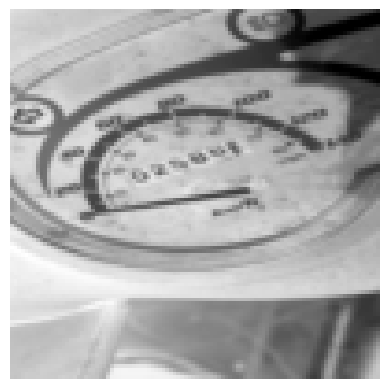

In [ ]:
plt.imshow(images[214], cmap=mpl.cm.binary)
plt.axis("off")

In [ ]:
from sklearn.model_selection import train_test_split
images = np.asarray(images)
labels = np.asarray(labels)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, stratify=labels)

In [ ]:
x_test

array([[[0.04586255, 0.04648449, 0.04660948, ..., 0.05172734,
         0.04266679, 0.03864133],
        [0.04755049, 0.04573463, 0.04596164, ..., 0.06293559,
         0.05913499, 0.04569632],
        [0.049741  , 0.04858141, 0.04850294, ..., 0.0469295 ,
         0.04266541, 0.03929042],
        ...,
        [0.27903845, 0.29503092, 0.29841883, ..., 0.11964375,
         0.12864939, 0.20306667],
        [0.32941659, 0.28282486, 0.2360247 , ..., 0.20561692,
         0.28175281, 0.3768567 ],
        [0.30101982, 0.24168752, 0.24388897, ..., 0.34352756,
         0.3934934 , 0.40780895]],

       [[0.43562188, 0.41820524, 0.40902882, ..., 0.23310203,
         0.23486876, 0.23740369],
        [0.42090225, 0.40259269, 0.40440967, ..., 0.23248408,
         0.23272638, 0.23579605],
        [0.40617545, 0.39559856, 0.39638158, ..., 0.23275521,
         0.23263008, 0.23433848],
        ...,
        [0.32607608, 0.33638546, 0.33653645, ..., 0.63392235,
         0.69045469, 0.75258513],
        [0.3

# KNN

In [ ]:
nsamples, nx, ny = x_train.shape
x_train_dataset = x_train.reshape((nsamples,nx*ny))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random

param_distribs_knn = [
        {'n_neighbors': randint(low=1, high=10), 'weights': ["uniform", "distance"], 'p': [1,2], 'leaf_size': randint(low=1, high=50), 'algorithm': ["ball_tree", "kd_tree"]},
    ]
knn = KNeighborsClassifier()
rnd_search_knn = RandomizedSearchCV(knn, param_distributions=param_distribs_knn,
                                n_iter=10, cv=5)
rnd_search_knn.fit(x_train_dataset, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'algorithm': ['ball_tree', 'kd_tree'],
                                         'leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c1b08fdf2b0>,
                                         'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c1b08fdf220>,
                                         'p': [1, 2],
                                         'weights': ['uniform', 'distance']}])

In [ ]:
rnd_search_knn.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 37,
 'n_neighbors': 2,
 'p': 1,
 'weights': 'distance'}

In [ ]:
nsamples, nx, ny = x_test.shape
x_test_dataset = x_test.reshape((nsamples,nx*ny))
y_knn_predicted = rnd_search_knn.predict(x_test_dataset)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy_score(y_test, y_knn_predicted)

0.8870292887029289

In [ ]:
precision_score(y_test, y_knn_predicted, average="binary", pos_label='digital')

0.8662790697674418

In [ ]:
recall_score(y_test, y_knn_predicted, average="binary", pos_label='digital')

0.9738562091503268

In [ ]:
f1_score(y_test, y_knn_predicted, average="binary", pos_label='digital')

0.916923076923077

In [ ]:
confusion_matrix(y_test, y_knn_predicted)

array([[126,  46],
       [  8, 298]])

# SVM

In [ ]:
from sklearn.svm import SVC

param_distribs = [
        {'kernel': ["linear"], 'C': randint(low=1, high=50), 'degree': randint(low=1, high=5)},
        {'kernel': ["rbf"], 'C': randint(low=1, high=50), 'gamma': ["scale", "auto"], 'degree': randint(low=1, high=5)},
    ]

svc = SVC()
rnd_search_svc = RandomizedSearchCV(svc, param_distributions=param_distribs,
                                n_iter=10, cv=5)
rnd_search_svc.fit(x_train_dataset, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c1af196a9e0>,
                                         'degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c1b08fdfc40>,
                                         'kernel': ['linear']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c1af1969cc0>,
                                         'degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c1b08fdfbb0>,
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['rbf']}])

In [ ]:
rnd_search_svc.best_params_

{'C': 33, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
y_svc_predicted = rnd_search_svc.predict(x_test_dataset)

In [ ]:
accuracy_score(y_test, y_svc_predicted)

0.9163179916317992

In [ ]:
precision_score(y_test, y_svc_predicted, average="binary", pos_label='digital')

0.934640522875817

In [ ]:
recall_score(y_test, y_svc_predicted, average="binary", pos_label='digital')

0.934640522875817

In [ ]:
f1_score(y_test, y_svc_predicted, average="binary", pos_label='digital')

0.934640522875817

In [ ]:
confusion_matrix(y_test, y_svc_predicted)

array([[152,  20],
       [ 20, 286]])

# Ada Boost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import uniform
param_distribs_abc = [
        {'n_estimators': randint(low=1, high=100),
         'learning_rate': uniform(0,1),
         "algorithm":["SAMME", "SAMME.R"],
         "random_state": randint(low=1, high=100)},
    ]

abc = AdaBoostClassifier()
rnd_search_abc = RandomizedSearchCV(abc, param_distributions=param_distribs_abc,
                                n_iter=10, cv=5)
rnd_search_abc.fit(x_train_dataset, y_train)

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(),
                   param_distributions=[{'algorithm': ['SAMME', 'SAMME.R'],
                                         'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a027395f670>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a027395cf70>,
                                         'random_state': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a0273562a70>}])

In [ ]:
rnd_search_abc.best_params_

{'algorithm': 'SAMME.R',
 'learning_rate': 0.23775994434754566,
 'n_estimators': 84,
 'random_state': 5}

In [ ]:
y_abc_predicted = rnd_search_abc.predict(x_test_dataset)

In [ ]:
accuracy_score(y_test, y_abc_predicted)

0.8451882845188284

In [ ]:
precision_score(y_test, y_abc_predicted, average="binary", pos_label='digital')

0.8493975903614458

In [ ]:
recall_score(y_test, y_abc_predicted, average="binary", pos_label='digital')

0.9215686274509803

In [ ]:
f1_score(y_test, y_abc_predicted, average="binary", pos_label='digital')

0.8840125391849529

In [ ]:
confusion_matrix(y_test, y_abc_predicted)

array([[122,  50],
       [ 24, 282]])

# Data Preparation For Reading

In [ ]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
from google.colab import drive
import pandas as pd


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

drive.mount('/content/drive', force_remount=True)

input_dir = "/content/drive/My Drive/Quota/ML/trodo-v01/trodo-v01/images"
input_dir_anno = "/content/drive/My Drive/Quota/ML/trodo-v01/trodo-v01/pascal voc 1.1/Annotations"

Mounted at /content/drive


In [ ]:
import xml.etree.ElementTree as ET
anno_list = []
odometer_list = []
for file in os.listdir(input_dir_anno):
      xml_path = os.path.join(input_dir_anno, file)
      tree = ET.parse(xml_path)
      root = tree.getroot()
      for anno_elem in root.findall('.//object'):
          anno_dict = {}
          if(anno_elem.find('name').text != 'X' and anno_elem.find('name').text != ','):
            anno_dict['filename'] = file
            anno_dict['name'] = anno_elem.find('name').text
            anno_dict['xmin'] = anno_elem.find('bndbox').find('xmin').text
            anno_dict['ymin'] = anno_elem.find('bndbox').find('ymin').text
            anno_dict['xmax'] = anno_elem.find('bndbox').find('xmax').text
            anno_dict['ymax'] = anno_elem.find('bndbox').find('ymax').text
            if(anno_elem.find('name').text == 'odometer'):
              odometer_list.append(anno_dict)
            else:
              anno_list.append(anno_dict)

In [ ]:
df = pd.DataFrame(anno_list)
df

,filename,name,xmin,ymin,xmax,ymax
0,00000124-PHOTO-2020-11-22-10-58-08.xml,0,313.78,967.64,343.32,989.52
1,00000124-PHOTO-2020-11-22-10-58-08.xml,1,316.11,945.55,345.18,953.48
2,00000124-PHOTO-2020-11-22-10-58-08.xml,8,313.78,909.97,344.01,931.85
3,00000124-PHOTO-2020-11-22-10-58-08.xml,4,315.41,824.85,336.57,841.62
4,00000124-PHOTO-2020-11-22-10-58-08.xml,9,317.27,880.67,346.11,903.01
...,...,...,...,...,...,...
21224,00001508-PHOTO-2020-12-15-22-19-58.xml,0,223.56,661.23,252.54,708.55
21225,00001508-PHOTO-2020-12-15-22-19-58.xml,7,230.9,608.78,255.48,650.23
21226,00001508-PHOTO-2020-12-15-22-19-58.xml,7,258.78,608.41,282.25,650.23
21227,00001508-PHOTO-2020-12-15-22-19-58.xml,5,297.0,658.3,326.71,710.38


In [ ]:
cropped_img = []
labelofimg = []
import tensorflow as tf
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

for file in os.listdir(input_dir):
  img_path = os.path.join(input_dir, file)
  for row in df.index:
    if(df['filename'][row] == file[:-3] + 'xml'):
      img = imread(img_path)
      image = tf.image.crop_to_bounding_box(img, int(float(df['ymin'][row])), int(float(df['xmin'][row])), int(float(df['ymax'][row]) - float(df['ymin'][row])), int(float(df['xmax'][row]) - float(df['xmin'][row])))
      image = rgb2gray(image)
      image = resize(image, (100,100))
      cropped_img.append(image)
      labelofimg.append(df['name'][row])

In [ ]:
dfodometer = pd.DataFrame(odometer_list)

(-0.5, 99.5, 99.5, -0.5)

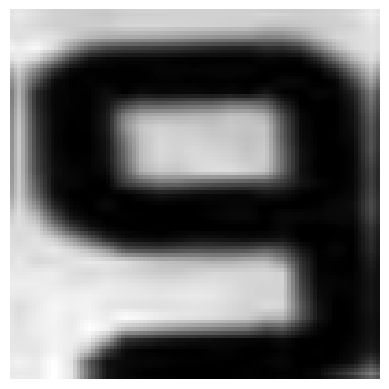

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.imshow(cropped_img[543], cmap=mpl.cm.binary)
plt.axis("off")

In [ ]:
odometer_img = []
labelofodometer = []

for file in os.listdir(input_dir):
  img_path = os.path.join(input_dir, file)
  for row in dfodometer.index:
    if(dfodometer['filename'][row] == file[:-3] + 'xml'):
      img = imread(img_path)
      image = tf.image.crop_to_bounding_box(img, int(float(dfodometer['ymin'][row])),
                                            int(float(dfodometer['xmin'][row])),
                                            int(float(dfodometer['ymax'][row]) - float(dfodometer['ymin'][row])),
                                            int(float(dfodometer['xmax'][row]) - float(dfodometer['xmin'][row])))
      image = rgb2gray(image)
      odometer_img.append(image)
      labelofodometer.append(file)

(-0.5, 495.5, 233.5, -0.5)

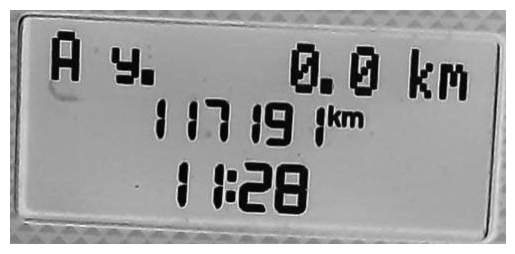

In [ ]:
plt.imshow(odometer_img[678], cmap=mpl.cm.binary)
plt.axis("off")

In [ ]:
from sklearn.model_selection import train_test_split
cropped_img = np.asarray(cropped_img)
labelofimg = np.asarray(labelofimg)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(cropped_img, labelofimg, test_size=0.2, shuffle=True, stratify=labelofimg)

In [ ]:
df.loc[df['filename'] == '00000573-PHOTO-2020-11-30-13-26-03.xml']

,filename,name,xmin,ymin,xmax,ymax
21205,00000573-PHOTO-2020-11-30-13-26-03.xml,9,547.2,364.28,559.44,384.44
21206,00000573-PHOTO-2020-11-30-13-26-03.xml,9,534.28,364.84,546.88,384.76
21207,00000573-PHOTO-2020-11-30-13-26-03.xml,8,603.81,337.82,616.92,360.28
21208,00000573-PHOTO-2020-11-30-13-26-03.xml,8,592.0,338.25,603.67,361.0
21209,00000573-PHOTO-2020-11-30-13-26-03.xml,8,627.61,336.26,641.8,359.4
21210,00000573-PHOTO-2020-11-30-13-26-03.xml,1,516.24,366.44,521.88,386.24
21211,00000573-PHOTO-2020-11-30-13-26-03.xml,1,579.72,363.44,585.72,383.36
21212,00000573-PHOTO-2020-11-30-13-26-03.xml,2,560.52,363.2,572.64,384.56
21213,00000573-PHOTO-2020-11-30-13-26-03.xml,0,471.5,367.7,483.7,387.5
21214,00000573-PHOTO-2020-11-30-13-26-03.xml,4,522.0,366.32,534.0,385.16
